In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import KernelPCA
import plotly.io as pio
from gtda.plotting import plot_diagram
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import glob

%matplotlib inline

# Load data

In [2]:
# Load all features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [4]:
subject_list = ["m292", "m294", "m298", "m299", "m300"]
label_list = [0, 1, 2, 3, 4]

In [5]:
data = {}

for subject in subject_list:
    data[subject] = np.load('Data/'+str(subject)+'/Data.npy', allow_pickle=True).item()

In [8]:
persistence_diagrams = {}
reshaped_persistence_diagrams = {}
extended_persistence_diagrams = {}
most_representative_diagrams = {}

for subject in subject_list:
    persistence_diagrams[subject] = {}
    reshaped_persistence_diagrams[subject] = {}
    extended_persistence_diagrams[subject] = {}
    most_representative_diagrams[subject] = {}

    
    for data_type in ["EEG", "EMG"]:

        most_representative_diagrams[subject][data_type] =  np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Most_Representative_Diagrams_(Extended_Diagrams).npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

        persistence_diagrams[subject][data_type]  = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

        
        extended_persistence_diagrams[subject][data_type] = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Extended_Persistence_Diagrams_All_Labels.npy', \
            allow_pickle=True).item() # .item() to convert the dtype to dict again

        reshaped_persistence_diagrams[subject][data_type] = {}

        for label in label_list:
            reshaped_persistence_diagrams[subject][data_type]["Label_"+str(label)] = [persistence_diagram[0] for persistence_diagram in list(persistence_diagrams[subject][data_type]["Label_"+str(label)])]

persistence_diagrams = reshaped_persistence_diagrams

# Plots directly from Time Series Data

## Plot time series of each label directly (complete)

In [ ]:
### Example for subject

subject = "m292"

In [ ]:

# Choose label 
label = 2

plt.plot(data[subject][label]["emg"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 20000,  40000,  60000,  80000,  100000,  120000,  140000], labels=[0, 10000,  20000,  30000,  40000,  50000,  60000,  70000])
plt.savefig('Plots/Example_EMG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
# Choose label 
label = 0

plt.plot(data[subject][label]["voltage"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 20000,  40000,  60000,  80000,  100000,  120000,  140000], labels=[0, 10000,  20000,  30000,  40000,  50000,  60000,  70000])
plt.savefig('Plots/Example_EEG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
# Choose label 
label = 4

plt.plot(data[subject][label]["voltage"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 20000,  40000,  60000,  80000,  100000,  120000,  140000], labels=[0, 10000,  20000,  30000,  40000,  50000,  60000,  70000])
plt.savefig('Plots/Example_EEG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

## Plot time series of each label directly (partly)

In [ ]:
label = 0

# Plot parts of the time series
plt.plot(data["m292"][label]["voltage"][:10000], linewidth=0.5)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 2000,  4000,  6000,  8000,  10000], labels=[0, 1000,  2000,  3000,  4000,  5000])
plt.savefig('Plots/Example_EEG_Masterthesis_Zoomed_In_Label_0.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
# Choose label 
label = 4

# Plot parts of the time series
plt.plot(data["m292"][label]["voltage"][:10000], linewidth=0.5)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 2000,  4000,  6000,  8000,  10000], labels=[0, 1000,  2000,  3000,  4000,  5000])
plt.savefig('Plots/Example_EEG_Masterthesis_Zoomed_In_Label_4.png')  # Save the plot as a PNG file
plt.show()

The higher the anesthesia level, the higher the frequency.

## Quantifying Amplitude and Frequency (Across all Subjects)

In [ ]:
def average_amplitude(time_series):
    return np.mean(np.abs(time_series))

def variance_of_amplitudes(time_series):
    abs_values = np.abs(time_series)
    return np.var(abs_values)


def average_top_10_percent(time_series):
    # Sort the values in descending order
    sorted_values = np.sort(time_series)[::-1]
    
    # Determine the index that corresponds to the 10th percentile
    percentile_index = int(len(sorted_values) * 0.1)
    
    # Take the subset of values corresponding to the top 10%
    top_10_percent_values = sorted_values[:percentile_index]
    
    # Calculate the average of the top 10% values
    average_top_10_percent_value = np.mean(top_10_percent_values)
    
    return average_top_10_percent_value


avg_amplitudes = {}
avg_variances = {}
avg_frequencies = {}
avg_top_10_percent_amplitudes = {}


for label in label_list:

    avg_amplitudes["Label_"+str(label)] = []
    avg_variances["Label_"+str(label)] = []
    avg_frequencies["Label_"+str(label)] = []
    avg_top_10_percent_amplitudes["Label_"+str(label)] = []


    for subject in subject_list:
        avg_amp = average_amplitude(data[subject][label]["voltage"])
        avg_amplitudes["Label_"+str(label)].append(avg_amp)

        variance_amp = variance_of_amplitudes(data[subject][label]["voltage"])
        avg_variances["Label_"+str(label)].append(variance_amp)

        top_amp = average_top_10_percent(np.array(data[subject][label]["voltage"]))
        avg_top_10_percent_amplitudes["Label_"+str(label)].append(top_amp)


amplitudes = []
amplitudes_std = []

variances = []
variance_std = []

top_amplitudes = []
top_amplitudes_std = []



for label in label_list:
    amplitudes.append(np.mean(avg_amplitudes["Label_"+str(label)]))
    amplitudes_std.append(np.std(avg_amplitudes["Label_"+str(label)]))
    
    variances.append(np.mean(avg_variances["Label_"+str(label)]))
    variance_std.append(np.std(avg_variances["Label_"+str(label)]))

    top_amplitudes.append(np.mean(avg_top_10_percent_amplitudes["Label_"+str(label)]))
    top_amplitudes_std.append(np.std(avg_top_10_percent_amplitudes["Label_"+str(label)]))



In [ ]:
from sklearn.linear_model import LinearRegression

def plot_correlation_with_std(labels, mean_values, std_values, y_axis_name):
    # Create scatter plot with error bars
    plt.errorbar(labels, mean_values, yerr=std_values, fmt='o', color='darkblue', ecolor='skyblue', capsize=4, markersize=8)

    # Set labels and title
    plt.xlabel('Labels', fontsize=14)
    plt.ylabel(y_axis_name, fontsize=14)

    # Fit linear regression model
    X = np.array(labels).reshape(-1, 1)  # Reshape to 2D array for sklearn
    model = LinearRegression()
    model.fit(X, mean_values)

    # Predict y-values using the linear regression model
    regression_line = model.predict(X)

    # Plot linear regression line
    plt.plot(labels, regression_line, color='indianred', linestyle='-', label='Ideal linear relationship', linewidth = 0.6)

    # Calculate extended line coordinates
    x_extended = np.array([-1, 5]).reshape(-1, 1)
    y_extended = model.predict(x_extended)

    # Plot extended line
    plt.plot(x_extended, y_extended, color='indianred', linestyle='--', linewidth = 0.6)

    # Set font size for ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-0.5, 4.5)


    # Save the plot as a PNG file
    plt.tight_layout()  
    plt.savefig('Plots/'+y_axis_name+'.png')

    # Show plot
    plt.show()


# Example usage:
labels = ["0", "1", "2", "3", "4"]

plot_correlation_with_std(labels, amplitudes, amplitudes_std, "Mean Time Series Amplitude")
plot_correlation_with_std(labels, variances, variance_std, "Variance in Time Series Amplitude")
plot_correlation_with_std(labels, top_amplitudes, top_amplitudes_std, "Top 10% Amplitudes")



## Correlation between Time Series and L1 norm of the signatures (Experimental)

This approach follows the idea of...

In [ ]:
# Choose label
label = 4
subject = "m292"
data_type = "EMG"

In [ ]:
# Choose signature here
SG = BettiCurve()
scaling_factor = 0.000005

#SG = BettiCurve()
#scaling_factor = 0.000000007

L1_norms = []


for diagram in persistence_diagrams[subject][data_type]["Label_"+str(label)]:
    signature = SG.fit_transform([diagram])
    L1_norms.append(scaling_factor*norm(signature[0][0], 1)) # scale TODO later introduce different y axes

In [ ]:
ts_segments_means = []

for idx in range(len(L1_norms)):
    # take average of all means
    ts_segments_means.append(np.mean(data[subject][label]["voltage"][2000*idx:2000*(idx+1)]))

In [ ]:
correlation = np.corrcoef(ts_segments_means, L1_norms)[0][1]
print("The correlation is " + str(round(correlation, 7))+".")

plt.plot(ts_segments_means[:50], label = "Time Series") 
plt.plot(L1_norms[:50], label = "Scaled L1 norm Persistence Landscape")
plt.legend()
plt.show()

## Result

Average absolute correlation across labels: 0.0643225 => No significant correlation.

# Dissimilarity matrices

## Dissimilarity matrix between labels for one feature

In [ ]:
# Get mean values of the features for each label

label = 0

mean_df = pd.DataFrame()

for label in label_list:
    filtered_df = feature_df[feature_df["Label"] == label]
    mean_df = pd.concat([mean_df, pd.DataFrame(filtered_df.describe().loc["mean"]).transpose()])

In [ ]:
# Choose one feature
feature = "EEG_Persistence Entropy_Dim_0"

# Don't consider label 7 because it will destroy the scaling 
z = np.array([complex(mean_df[feature][mean_df["Label"] == label], mean_df[feature][mean_df["Label"] == label]) for label in [0, 1, 2, 3, 4]])

m, n = np.meshgrid(z, z)
# get the distance via the norm
distance_matrix = abs(m-n)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    distance_matrix,
    cmap='OrRd',
    linewidth=1,
    xticklabels = [0, 1, 2, 3, 4],
    yticklabels = [0, 1, 2, 3, 4]
)

## Dissimilarity matrix of barycenters

In [ ]:
subject = "m292"
data_type = "EEG"

In [ ]:
# TODO create helper functions for these

def find_largest_dimension(persistence_diagrams, label_list):
    """
    Find the length of the longest list in a list of lists.

    Parameters:
    - persistence_diagrams (dictionary): List of persistence diagrams, with labels as keys.
    - label_list (list): List of all labels.

    Returns:
    - longest_lengths_each_dimension (dictionary): Highest amount of holes in a persistence diagram for each dimension.
    """

    # Initialize highest number of holes of each dimension for each label
    longest_lengths_each_dimension = {}
    for label in label_list:
        longest_lengths_each_dimension["Label_"+str(label)] = {}

        for hole_dim in range(3):
            longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)] = 0

    for label in label_list:

        # Only look at persistence diagrams of current label
        persistence_diagrams_with_label = persistence_diagrams["Label_"+str(label)]


        # For each hole dimension (between 0 and 2), find the largest amount of holes
        # of this dimension which there is in one of the persistence diagrams
        
        for hole_dim in range(3):

            # for the current hole dimension, count the amount of holes in each diagram
            for diagram in persistence_diagrams_with_label:
                current_number_of_holes_of_hole_dim = 0 # Initialize
                
                for hole in diagram[0]: # the holes are nested, so take diagram[0]
                    # only take those holes of the current hole dimension into account
                    # (the hole dimension is indicated by the 3rd entry of the hole)
                    if hole[2] == hole_dim:
                        current_number_of_holes_of_hole_dim += 1

                # If the amount of holes of the current diagram is higher than the 
                # previous highest number of holes, redefine the highest number
                if current_number_of_holes_of_hole_dim > longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)]:
                    longest_lengths_each_dimension["Label_"+str(label)]["Hole_Dim_"+str(hole_dim)] = current_number_of_holes_of_hole_dim

    # Because this is what we want in this case, compute the overall longest dimensions which we will use for all labels
    longest_lengths_each_dimension_overall = {key: max(label_dict[key] for label_dict in longest_lengths_each_dimension.values())
    for key in ['Hole_Dim_0', 'Hole_Dim_1', 'Hole_Dim_2']}
    
    return longest_lengths_each_dimension_overall


def extend_diagrams_to_largest_dimensions(persistence_diagrams, desired_lengths_each_dimension, label_list):
    """
    Extend all persistence diagrams to the largest dimension 
    by appending (0, 0, hole_dim) tuples.

    Parameters:
    - persistence_diagrams (dict): List of persistence_diagrams of each label.
    - longest_lengths_each_dimension_overall (dict): Contains the wished amount of holes for each dimension.
    - label_list (list): List of all labels.

    Returns:
    - extended_persistence_diagrams (dict): List of extended eprsistence_diagrams for each label.
    """

    # Initialize dictionary of extended persistence diagrams (with labels as keys)
    extended_persistence_diagrams = {}

    for label in label_list:

        # Initialize extended persistence diagrams for current label
        extended_persistence_diagrams["Label_"+str(label)] = []
        
        # Only look at persistence diagrams of current label
        persistence_diagrams_with_label = persistence_diagrams["Label_"+str(label)]

        # Extend each diagram to the highest number of holes for each dimension
        for diagram in persistence_diagrams_with_label:

            extended_diagram = list(diagram[0])
            
            for hole_dim in range(3):

                # the persistence diagrams are nested, so take diagram[0]                    
                current_number_of_holes_of_hole_dim = sum(1 for hole in diagram[0] if hole[2] == hole_dim)


                holes_to_append = [[0, 0, hole_dim]] * (desired_lengths_each_dimension["Hole_Dim_"+str(hole_dim)] - current_number_of_holes_of_hole_dim)
                extended_diagram = extended_diagram + holes_to_append
                
            extended_persistence_diagrams["Label_"+str(label)].append(extended_diagram)
            
    return extended_persistence_diagrams


In [ ]:
reshaped_barycenters = {}

for label in label_list:
    reshaped_barycenters["Label_"+str(label)] = [most_representative_diagrams[subject][data_type]["Label_"+str(label)]]

In [ ]:
longest_lengths_each_dimension_overall = find_largest_dimension(reshaped_barycenters, label_list)
extended_persistence_diagrams = extend_diagrams_to_largest_dimensions(reshaped_barycenters, longest_lengths_each_dimension_overall, label_list)

In [ ]:
reshaped_barycenters = {}

for label in label_list:
    reshaped_barycenters["Label_"+str(label)] = most_representative_diagrams["Label_"+str(label)][0]

In [ ]:
# Wasserstein barycenter
pairwise_distances = PairwiseDistance(metric="wasserstein").fit_transform(list(reshaped_barycenters.values()))

# plot it with seaborn
plt.figure(figsize=(10,10))
ax = sns.heatmap(pairwise_distances,
    cmap='inferno', 
    linewidth=1,
    xticklabels=[0, 1, 2, 3, 4],
    yticklabels=[0, 1, 2, 3, 4],
    cbar_kws={'shrink': 1}
)


# Change the font size of the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.set_xlabel('Label', fontsize=20)
ax.set_ylabel('Label', fontsize=20)


plt.savefig('Plots/Dissimilarity_Matrix_Barycenters_'+str(subject)+'_'+str(data_type)+'.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Box plots

In [ ]:
# Choose feature to plot box plot

feature = "EEG_Persistence Entropy_Dim_0"

explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 0])
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 2])
explored_feature.append(feature_df[feature][feature_df["Label"] == 3])
explored_feature.append(feature_df[feature][feature_df["Label"] == 4])

plt.boxplot(explored_feature)

# show plot
plt.title("Distribution of Amplitude of Persistence Entropy of Dimension 2 over Anesthesia Levels (EMG)")
plt.xticks(ticks = [1, 2,  3,  4, 5], labels=["Label 0", "Label 1",  "Label 2", "Label 3", "Label 4"])
plt.savefig('Plots/Box_Plot_'+str(feature)+'.png')
plt.show()


# Signatures

## Heat Kernel

In [ ]:
subject = "m292"
data_type = "EEG"

In [ ]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

In [ ]:
if data_type == "EEG":
    HK = HeatKernel(sigma=0.2, n_bins=100)
elif data_type == "EMG":
    HK = HeatKernel(sigma=0.003, n_bins=100)

In [ ]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

In [ ]:
label = 0
heatkernel = HK.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

In [ ]:
print("Heat kernel intensity of label " + str(label) + " for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

fig = HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 0 (Label " + str(label) + ").png")


In [ ]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 1: " + str(heat_kernel_intensity(heatkernel, 1)))


fig = HK.plot(heatkernel, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 1 (Label "+str(label)+").png")

In [ ]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 2: " + str(heat_kernel_intensity(heatkernel, 2)))


fig = HK.plot(heatkernel, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 2 (Label "+str(label)+").png")

# Persistence Landscape

In [ ]:
PL = PersistenceLandscape()

In [ ]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": False,  # Hide the legend
        "title": "", # Remove the title
        "height": 500,  # Set the desired height in pixels
        "margin": dict(l=150, r=50, t=50, b=100)  # Adjust margins if needed
    }
}


In [ ]:
import plotly.io as pio

label = 4
landscape = PL.fit_transform(most_representative_diagrams[subject][data_type]["Label_" + str(label)])

# Generate the initial plot
fig = PL.plot(landscape, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"

# Update layout to add combined axis labels and increase legend font size
fig.update_layout(
    annotations=[
        dict(
            text="Filtration Parameter",
            x=0.5,
            y=-0.2,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=18)
        ),
        dict(
            text="Persistence",
            x=-0.1,
            y=0.5,
            xref="paper",
            yref="paper",
            showarrow=False,
            textangle=-90,
            font=dict(size=18)
        )
    ],
    margin=dict(l=100, r=20, t=100, b=100),  # Adjust margins if necessary
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Landscape_" + str(subject) + "_" + str(data_type) + "(Label " + str(label) + ").png")


# Silhouette

In [ ]:
SH = Silhouette()

In [ ]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Silhouette Value",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


In [ ]:
label = 0


silhouette = SH.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = SH.plot(silhouette, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Silhouette_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Betti Curve

In [ ]:
BC = BettiCurve()


In [ ]:
# Parameters for Plotting
plotly_params = {
    "layout": {
        "showlegend": True,  # Hide the legend
        "title": "", # Remove the title
        "height": 300,  # Set the desired height in pixels
        "margin": dict(l=100, r=50, t=50, b=100),
        "xaxis": {
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Betti Number",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}


In [ ]:
label = 0

betti_curve = BC.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])


fig = BC.plot(betti_curve, homology_dimensions=[0, 1, 2], plotly_params=plotly_params)

# Update trace names to change legend text
for i, trace in enumerate(fig.data):
    if i == 0:
        trace.name = "Dim 0"
    elif i == 1:
        trace.name = "Dim 1"
    elif i == 2:
        trace.name = "Dim 2"


fig.update_layout(
    legend=dict(
        font=dict(
            size=18  # Set the desired font size for the legend
        )
    )
)


# Update the layout to add combined axis labels

fig.show()


# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/Betti_Curve_"+str(subject)+"_"+str(data_type)+"(Label "+str(label)+").png")

# Persistence Images

In [12]:
if data_type == "EEG":
    PI = PersistenceImage(sigma=0.2, n_bins=100)
elif data_type == "EMG":
    PI = PersistenceImage(sigma=0.003, n_bins=100)



In [13]:
# Parameters for plotting

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Center the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,
        "height": 650,
        "xaxis": {
            "title": "Birth",  # Add label for x-axis
            "titlefont": {"size": 22},  # Set font size for x-axis label
            "tickfont": {"size": 18}  # Set font size for x-axis ticks
        },
        "yaxis": {
            "title": "Death",  # Add label for y-axis
            "titlefont": {"size": 22},  # Set font size for y-axis label
            "tickfont": {"size": 18}  # Set font size for y-axis ticks
        }
    }
}

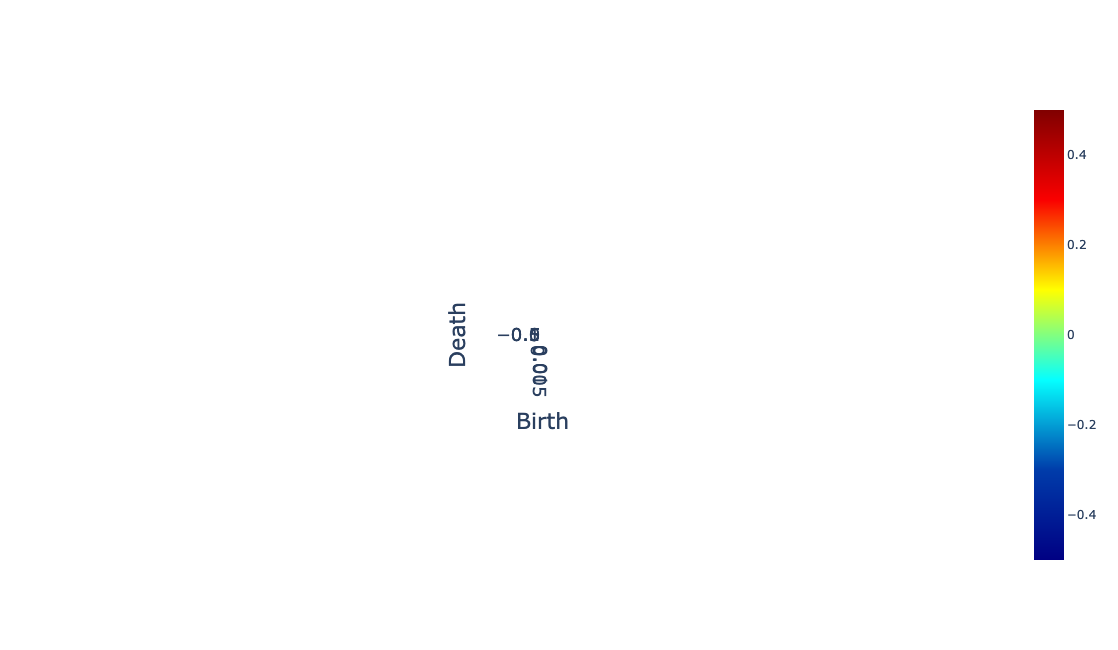

In [14]:
label = 4


persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 0 (Label " + str(label) + ").png")

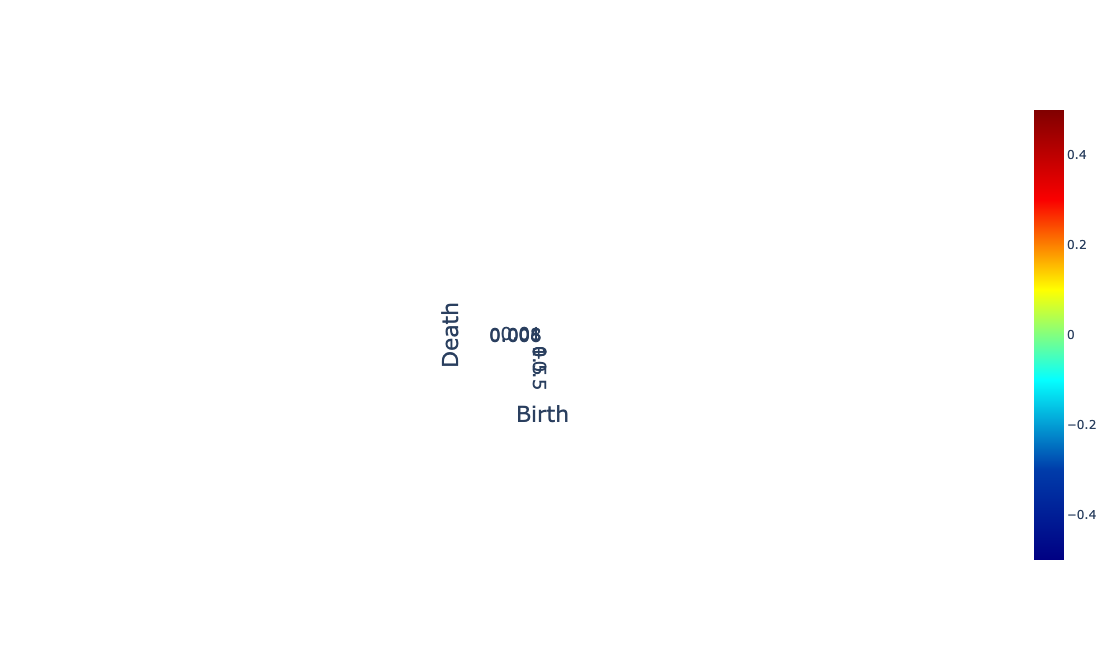

In [15]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 1 (Label " + str(label) + ").png")

In [ ]:
persistence_image = PI.fit_transform(most_representative_diagrams[subject][data_type]["Label_"+str(label)])

fig = PI.plot(persistence_image, homology_dimension_idx=2, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Persistence Image of Dimension 2 (Label " + str(label) + ").png")

# Dimensionality reduced visualizations of Signature Vectorizations

First of all, combine all (extended persistence diagrams) to later examine the visualizations for clusters.

In [ ]:
all_extended_diagrams = []

for label in label_list:
    all_extended_diagrams = all_extended_diagrams + extended_persistence_diagrams["Label_"+str(label)]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing this for 3D plotting
import umap.umap_ as umap  # Correcting the import for UMAP

def separate_signature_according_to_dimension(signature):
    """
    Separate the landscape vectors according to each dimension.

    Parameters:
    - signature (list): Signature vector.

    Returns:
    - vectors (dict): Dictionary containing lists of vectors for each dimension.
    """
    vectors = {}
    
    for hom_dim in range(3):
        vectors["Dimension_" + str(hom_dim)] = []
        
        for vector_for_single_diagram in signature:
            vectors["Dimension_" + str(hom_dim)].append(vector_for_single_diagram[hom_dim])
    
    return vectors

def compute_umap_embedding(complete_data, data_list, homology_dimension, random_state=1):
    """
    Perform UMAP dimensionality reduction to 3 dimensions.

    Parameters:
    - signature (list): List containing the signature data.

    Returns:
    - embedding (numpy array): The 3-dimensional UMAP embedding.
    """
    # Perform UMAP dimensionality reduction to 3 dimensions


    reducer = umap.UMAP(n_components=3, random_state=random_state)
    
    reducer.fit(complete_data)
    
    embeddings = []

    for label in range(5):
        embeddings.append(reducer.transform(data_list["Label_"+str(label)]["Dimension_"+str(homology_dimension)]))
    
    return embeddings


def visualize_embedding(list_of_embeddings, title="Signature"):
    """
    Visualize two 3-dimensional UMAP embeddings in the same plot.

    Parameters:
    - list_of_embeddings (list): List of arrays with the first 3-dimensional UMAP embedding.
    - title (str): Title for the plot.

    Returns:
    None
    """
    # Visualize the embeddings
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plots for each label
    for i, embedding in enumerate(list_of_embeddings):
        ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=f'Label {i}', color=['blue', 'blueviolet', 'purple', 'crimson', 'red'][i])

    ax.set_xlabel('Dimension 1', fontsize=18)
    ax.set_ylabel('Dimension 2', fontsize=18)
    ax.set_zlabel('Dimension 3', fontsize=18)
    ax.set_title("")

    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=13)

    plt.savefig('Plots/'+str(title)+'.png', bbox_inches='tight')

    plt.show()



def compute_kernel_pca_embedding(complete_data, data_list, homology_dimension, kernel='rbf', n_components=3):
    """
    Compute a Kernel PCA reduced embedding with 3 dimensions.
    
    Parameters:
        data (numpy.ndarray): Input data matrix of shape (n_samples, n_features).
        kernel (str): Kernel function to be used ('rbf', 'poly', 'sigmoid', 'linear').
        n_components (int): Number of components for dimensionality reduction.
        
    Returns:
        numpy.ndarray: Kernel PCA reduced embedding of shape (n_samples, 3).
    """
    # Initialize Kernel PCA with specified kernel function
    kpca = KernelPCA(kernel=kernel, n_components=n_components, random_state=42)

    kpca.fit(complete_data[0][homology_dimension])
    
    # Fit and transform the data
    embeddings = []

    for label in range(5):
        embeddings.append(kpca.transform(data_list["Label_"+str(label)][0][homology_dimension]))
    
    return embeddings
    


## Betti Curve

In [ ]:
BC = BettiCurve()

In [ ]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = BC.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

In [ ]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


In [ ]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


In [ ]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


## Silhouette

In [ ]:
SH = Silhouette()

In [ ]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

In [ ]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


In [ ]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


In [ ]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


## Landscape

In [ ]:
PL = PersistenceLandscape()

In [ ]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

In [ ]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

In [ ]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

In [ ]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

# Finding clusters in Features Directly

In [6]:
# All features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [7]:
# Choose m292 as subject
subject_df = feature_df[feature_df["Subject"] == 1]

### Set plot parameters ####

num_points_per_label = 74

# Define the colors for each label
colors=['blue', 'blueviolet', 'purple', 'crimson', 'red']


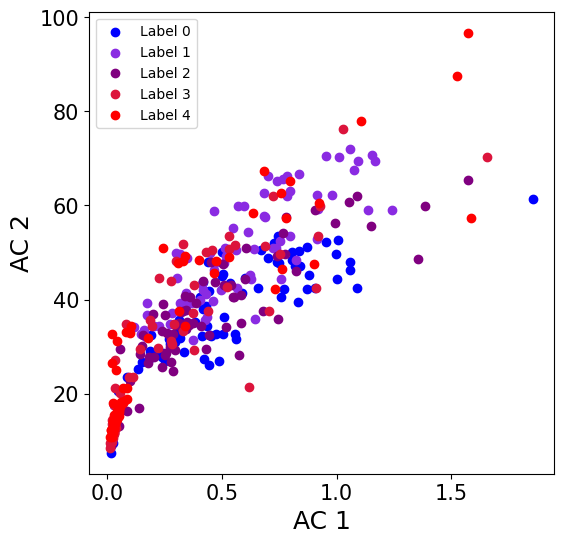

In [8]:
# Plotting the points
plt.figure(figsize=(6, 6))

# Plot each segment with the corresponding color
for i, color in enumerate(colors):
    start_idx = i * num_points_per_label
    end_idx = start_idx + num_points_per_label
    plt.scatter(subject_df['EEG_AC_coordinate_cc1'][start_idx:end_idx],
                subject_df['EEG_AC_coordinate_cc2'][start_idx:end_idx],
                color=color, label=f'Label {i}')

# Adding labels and title
plt.xlabel('AC 1', fontsize=18)
plt.ylabel('AC 2', fontsize=18)
plt.title('')

plt.tick_params(axis='both', which='major', labelsize=15)

# Add legend to differentiate the labels
plt.legend()

# Save the plot
plt.savefig('Plots/EEG Clustering AC 1 & 2.png', bbox_inches='tight')

# Display the plot
plt.show()

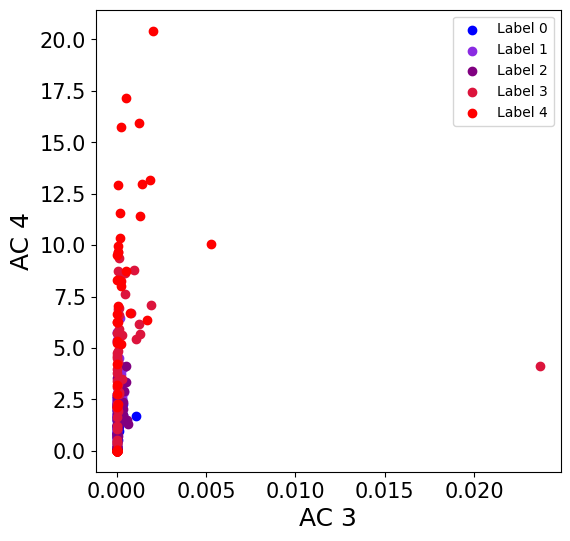

In [9]:
# Plotting the points
plt.figure(figsize=(6, 6))

# Plot each segment with the corresponding color
for i, color in enumerate(colors):
    start_idx = i * num_points_per_label
    end_idx = start_idx + num_points_per_label
    plt.scatter(subject_df['EEG_AC_coordinate_cc3'][start_idx:end_idx],
                subject_df['EEG_AC_coordinate_cc4'][start_idx:end_idx],
                color=color, label=f'Label {i}')

# Adding labels and title
plt.xlabel('AC 3', fontsize=18)
plt.ylabel('AC 4', fontsize=18)
plt.title('')

plt.tick_params(axis='both', which='major', labelsize=15)

# Add legend to differentiate the labels
plt.legend()

# Save the plot
plt.savefig('Plots/EEG Clustering AC 3 & 4.png', bbox_inches='tight')

# Display the plot
plt.show()
